### Model training

In [1]:
from fastai.collab import *
from fastai.tabular.all import *
from pathlib import Path
path = Path()
from torch.nn import Module

In [2]:
games = pd.read_csv('games_detailed_info.csv', index_col=0)
# id2name = {i:n for i, n in zip(games['id'], games['primary'])}

C:\Users\Gebruiker\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (28,47) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
ratings = pd.read_csv(path/'bgg-19m-reviews.csv', index_col=0)
REVIEW_CUTOFF = 10
counts = ratings.groupby('user').agg(count=('rating', 'count')).reset_index()
ratings_incl_count = ratings.merge(counts)
experienced_ratings = ratings_incl_count.loc[ratings_incl_count['count'] > REVIEW_CUTOFF]
len(experienced_ratings)
# ratings = experienced_ratings.sample(frac=0.3)

18318722

In [17]:
transform_ratings(experienced_ratings)['rating'].mean()

5.210387257567308

In [18]:
def transform_ratings(ratings):
    df = ratings.copy()
    df['rating'] = ((df['rating'] ** 2)/10).copy()
    return df
    

def get_dls(df, bs, method='simple'):
    if method =='transform':
        df = transform_ratings(df)
    dls = CollabDataLoaders.from_df(df, bs=bs, item_name='name', user_name='user', rating_name='rating', seed = 112)
    return dls


In [13]:
def create_params(size):
    return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))

class DotProductBias(Module):
    def __init__(self, n_users, n_games, n_factors, y_range=(0.5,10.5)):
        super().__init__()
        self.user_factors = create_params([n_users, n_factors])
        self.user_bias = create_params([n_users])
        self.game_factors = create_params([n_games, n_factors])
        self.game_bias = create_params([n_games])
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors[x[:,0]]
        games = self.game_factors[x[:,1]]
        res = (users*games).sum(dim=1)
        res += self.user_bias[x[:,0]] + self.game_bias[x[:,1]]
        return sigmoid_range(res, *self.y_range)

In [14]:
bs = 16384
lr = 0.0065
wd = 0.15
emb_size = 30
cycles = 3

dls = get_dls(experienced_ratings, bs)
n_users  = len(dls.classes['user'])
n_games = len(dls.classes['name'])
model = DotProductBias(n_users, n_games, emb_size, y_range=(0,11))
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(cycles, lr, wd=wd)

epoch,train_loss,valid_loss,time
0,1.540472,1.531904,00:37
1,1.394194,1.411204,00:34
2,1.241954,1.389589,00:33


In [19]:
dls = get_dls(experienced_ratings, bs, method='transform')
n_users  = len(dls.classes['user'])
n_games = len(dls.classes['name'])
model = DotProductBias(n_users, n_games, emb_size, y_range=(0,11))
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(cycles, lr, wd=wd)

epoch,train_loss,valid_loss,time
0,2.630027,2.622897,00:39
1,2.407219,2.450711,00:40
2,2.104239,2.428423,00:39


In [25]:
save_pickle('models/size30.pickle', learn)
save_pickle('models/size30model.pickle', model)
save_pickle('models/dls.pickle', dls)
save_pickle('models/userids.pickle', dls.classes['user'])
save_pickle('models/gameids.pickle', dls.classes['name'])

In [26]:
gameids = load_pickle('models/gameids.pickle')
def add_model_id_to_gamedf(df_games, gameids):
    new = pd.DataFrame({'name':gameids})
    new_complete = new.merge(df_games.drop_duplicates('name'), how='left', left_on='name', right_on='name')
    return new_complete
new_complete = add_model_id_to_gamedf(games, gameids)
new_complete['usersrated'] = new_complete['usersrated'].fillna(0)
new_complete['usersrated'] = new_complete['usersrated'].astype(int)

def img_html(name, thumb, bggid):
    
    img =  f'<img src="{thumb}" style="border: none; width: 100%;" alt="{name}">'
    return f'<a href="https://boardgamegeek.com/boardgame/{bggid}">{img}</a>'
 
# new_complete.rename(columns={'name':'name2'})
new_complete['thumbnail'] = new_complete.apply(lambda x: img_html(x['name'], x['thumbnail'], x['id']), axis=1)



# new_complete.to_csv(r'streamlit/input/games_detailed_info_incl_modelid.csv')


In [27]:
new_complete['thumbnail'][4]

'<a href="https://boardgamegeek.com/boardgame/nan"><img src="nan" style="border: none; width: 100%;" alt=""Tarleton\'s Quarter!""></a>'

### Model performance

In [28]:
def compute_loss_stats(df):
    df['loss'] = df['actual'] - df['preds']
    df['squareloss'] = df['loss']**2
    df['absloss'] = abs(df['loss'])
    return df.describe()

In [29]:
# The actual performance, look at the squaredloss mean and absloss mean
preds = learn.get_preds(with_input=True, with_loss=False, with_decoded=False)
df = pd.DataFrame({'preds':preds[1].numpy(), 'actual':preds[2].numpy().flatten()})
compute_loss_stats(df)

,preds,actual,loss,squareloss,absloss
count,3.663744e+06,3.663744e+06,3.663744e+06,3.663744e+06,3.663744e+06
mean,5.229487e+00,5.209791e+00,-1.969731e-02,2.428424e+00,1.180915e+00
std,1.335215e+00,2.091502e+00,1.558216e+00,4.264849e+00,1.016791e+00
min,1.193287e-01,0.000000e+00,-9.895683e+00,0.000000e+00,0.000000e+00
25%,4.349657e+00,3.600000e+00,-9.481082e-01,1.747301e-01,4.180073e-01
50%,5.212126e+00,4.900000e+00,-4.957986e-02,8.345421e-01,9.135327e-01
75%,6.097157e+00,6.400000e+00,8.756349e-01,2.757520e+00,1.660578e+00
max,1.077523e+01,1.000000e+01,9.830468e+00,9.792455e+01,9.895683e+00


In [30]:
# baseline, with always predicting the mean of the ratings
df['preds'] = df['actual'].mean()
compute_loss_stats(df)

,preds,actual,loss,squareloss,absloss
count,3.663744e+06,3.663744e+06,3.663744e+06,3.663744e+06,3.663744e+06
mean,5.209799e+00,5.209791e+00,5.650145e-07,4.374380e+00,1.648942e+00
std,0.000000e+00,2.091502e+00,2.091502e+00,6.069710e+00,1.286612e+00
min,5.209791e+00,0.000000e+00,-5.209791e+00,1.120507e-07,3.347397e-04
25%,5.209791e+00,3.600000e+00,-1.609791e+00,1.723988e-01,4.152093e-01
50%,5.209791e+00,4.900000e+00,-3.097906e-01,1.416598e+00,1.190209e+00
75%,5.209791e+00,6.400000e+00,1.190209e+00,7.342966e+00,2.709791e+00
max,5.209791e+00,1.000000e+01,4.790209e+00,2.714192e+01,5.209791e+00


In [35]:
# better baseline, with always predicting the mean of the game
def gameid(gamename):
    return dls.classes['name'].o2i[gamename]
games_avg = transform_ratings(experienced_ratings).groupby('name').agg(preds=('rating', 'mean'))
games_avg.reset_index(inplace=True)
games_avg.head()
games_avg['id'] = games_avg['name'].apply(gameid)
test_input = pd.DataFrame({'id':preds[0].numpy()[:,1]})
test_input_avg = test_input.merge(games_avg, how='left')
print(len(test_input_avg))
df['preds'] = test_input_avg['preds']
compute_loss_stats(df)

3663744


,preds,actual,loss,squareloss,absloss
count,3.663744e+06,3.663744e+06,3.663744e+06,3.663744e+06,3.663744e+06
mean,5.209996e+00,5.209791e+00,-2.050672e-04,3.386497e+00,1.414686e+00
std,9.952387e-01,2.091502e+00,1.840244e+00,5.418748e+00,1.176929e+00
min,1.000000e-01,0.000000e+00,-8.700000e+00,2.220446e-18,1.490116e-09
25%,4.601719e+00,3.600000e+00,-1.125677e+00,2.512065e-01,5.012051e-01
50%,5.275023e+00,4.900000e+00,-5.639192e-02,1.213343e+00,1.101519e+00
75%,5.867801e+00,6.400000e+00,1.084354e+00,4.046668e+00,2.011633e+00
max,9.171267e+00,1.000000e+01,9.400000e+00,8.836000e+01,9.400000e+00


* avg random has squaredloss 3.785315	and mae 1.549492
* baseline everything 7 has squaredloss 2.4 and mae 1.17
* baseline everything avg game score has squaredloss 1.93 and mae 1.03
* model has squaredloss of 1.3 and mae 0.86
with **2/10
<!-- * avg random has squaredloss 3.785315	and mae 1.549492 -->
* baseline everything mean has squaredloss 4.4 and mae 1.6
* baseline everything avg game score has squaredloss 3.3 and mae 1.4
* model has squaredloss of 2.4 and mae 1.2

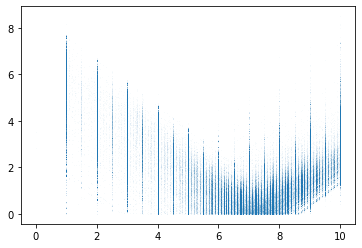

In [251]:
plt.scatter(df['actual'], df['absloss'],s=0.0001);

## Interpreting Embeddings and Biases

In [193]:
def gameid(gamename):
    return dls.classes['name'].o2i[gamename]
def userid(username):
    return dls.classes['user'].o2i[username]

def search_game(gamename):
    return [(name, idx) for idx, name in enumerate(dls.classes['name']) if gamename in name]
def search_user(username):
    return [(name, idx) for idx, name in enumerate(dls.classes['user']) if username in name]

def get_user_preds(user):
    user_idx = userid(user)

    preds = ((user_factors[user_idx] * game_factors).sum(dim=1) + game_bias + user_bias[user_idx])
    preds = sigmoid_range(preds, 0,11)
    return preds

def get_user_best(user, n=100):
    preds = get_user_preds(user)
    best_idx = preds.argsort(descending=True)[0:n]
    return dls.classes['name'][best_idx]

def get_game_preds(game):
    if isinstance(game,int):
        game_idx = game
    else:
        game_idx = gameid(game)

    preds = ((game_factors[game_idx] * user_factors).sum(dim=1) + user_bias + game_bias[game_idx])
    preds = sigmoid_range(preds, 0,11)
    best_idx = preds.argsort(descending=True)[0:10]
    # print(preds.sort(descending=True)[0:10])
    dls.classes['user'][best_idx]
    return preds



In [172]:
learn = load_pickle('models/1373.pickle')
dls = load_pickle('models/dls.pickle')
game_bias = learn.model.game_bias
game_factors = learn.model.game_factors
user_bias = learn.model.user_bias
user_factors = learn.model.user_factors
game_factors.shape, user_factors.shape, user_bias.shape, game_bias.shape

In [253]:
# the best games bias
idxs = game_bias.argsort(descending=True)[:10]
[dls.classes['name'][i] for i in idxs]

['Clank!: Legacy – Acquisitions Incorporated',
 'Pandemic Legacy: Season 1',
 'Eclipse: Second Dawn for the Galaxy',
 'Gloomhaven',
 'Brass: Birmingham',
 'Twilight Imperium: Fourth Edition',
 'Ark Nova',
 'Terraforming Mars',
 'Too Many Bones: Undertow',
 'Gloomhaven: Jaws of the Lion']

In [254]:
# the worst biases
idxs = game_bias.argsort()[:10]
[dls.classes['name'][i] for i in idxs]

['Alien: USCSS Nostromo',
 'Global Survival',
 "Oneupmanship: Mine's Bigger",
 'Chutes and Ladders',
 'Tic-Tac-Toe',
 'Candy Land',
 'Overturn: Rising Sands',
 'Intelligent Design vs. Evolution',
 'War',
 'Bingo']

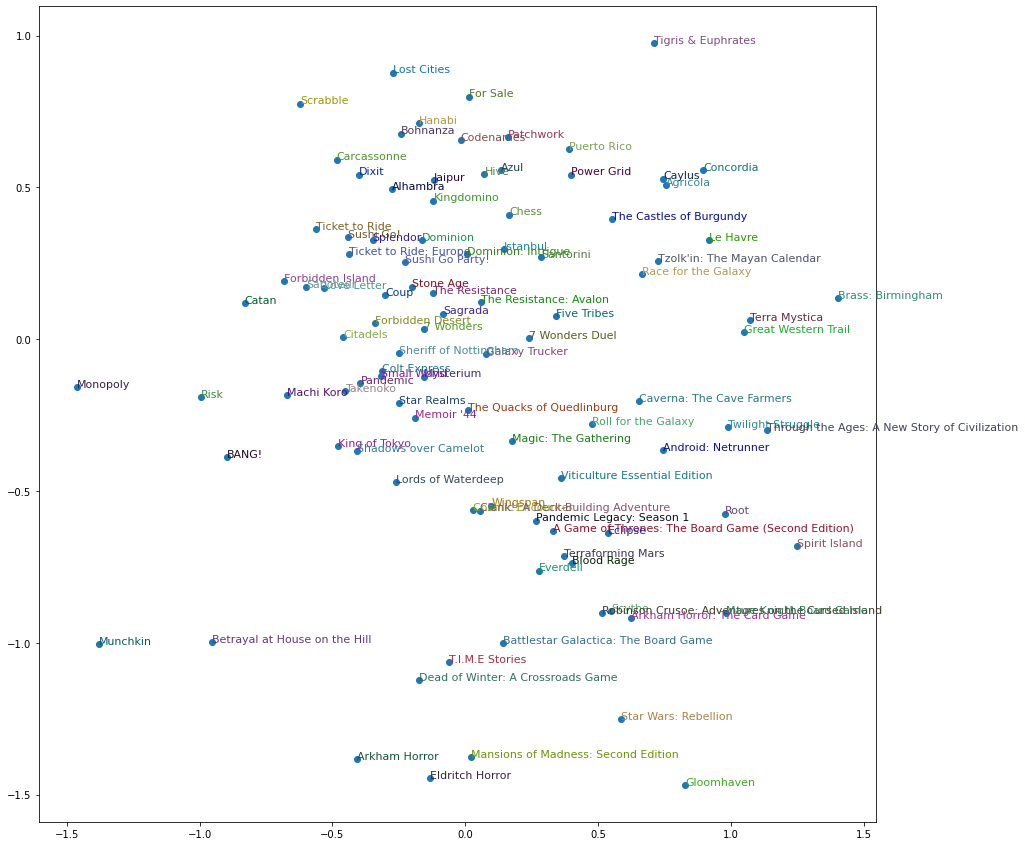

In [178]:
#hide_input
#id img_pca_game
#caption Representation of games based on two strongest PCA components
#alt Representation of games based on two strongest PCA components
g = ratings.groupby('name')['rating'].count()
top_games = g.sort_values(ascending=False).index.values[:2000]
top_idxs = tensor([learn.dls.classes['name'].o2i[m] for m in top_games])
game_w = learn.model.game_factors[top_idxs].cpu().detach()
game_pca = game_w.pca(3)
fac0,fac1,fac2 = game_pca.t()
idxs = list(range(0,100))
X = fac0[idxs]
Y = fac1[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_games[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

In [28]:
# most negative users
idxs = user_bias.argsort(descending=False)[:15]
[dls.classes['user'][i] for i in idxs]

['yahoo79',
 'x_AMK_x',
 'himokl',
 'Munt74',
 'Xssassin',
 'jobirnbaum',
 'fluffystark',
 'GoddessInTriptych',
 'SANE9383',
 'HiTracey',
 'andrebr',
 'unplayedratings',
 'TheRock32',
 'waldo0',
 'Discrepo']

In [27]:
# most positive users
idxs = user_bias.argsort(descending=True)[:15]
[dls.classes['user'][i] for i in idxs]

['TheBardGamer',
 'The Eraser',
 'ledzep571',
 'wejejeei',
 'tlaraver',
 'RonCarlson01',
 'paintime',
 'Ty Bomba',
 'ChiDrago',
 'BoardGamer2008',
 'wargamediehard1',
 'Frasco8a',
 'Marysinka',
 'shantke',
 'aca83']

In [194]:
search_game('Agricol')

[('Agricola', 759),
 ('Agricola (Revised Edition)', 760),
 ('Agricola Express', 761),
 ('Agricola, Master of Britain', 762),
 ('Agricola: All Creatures Big and Small', 763),
 ('Agricola: Family Edition', 764),
 ('Agricola: Roman Campaign in Britain, AD 82-84', 765)]

### Checking TomVasels top 10 with the model predictions

In [30]:
preds = get_user_preds("TomVasel")
idxs = [10208, 16316,4184,14028,3639,3639,17614,17902,429,20122]
for idx in idxs:
    game_pred = get_game_preds(idx).mean().item()
    print(dls.classes['name'][idx], preds[idx].item(), game_pred)

Le Havre 7.612617492675781 7.750667572021484
Space Base 8.64084243774414 7.6392388343811035
Cosmic Encounter 9.829557418823242 7.511444568634033
Project: ELITE 8.673273086547852 7.79048490524292
Chronicles of Crime 9.27065372467041 7.540925979614258
Chronicles of Crime 9.27065372467041 7.540925979614258
Terraforming Mars 8.307674407958984 8.378286361694336
The Crew: The Quest for Planet Nine 8.553868293762207 7.926290988922119
A Feast for Odin 7.261257648468018 8.159873008728027
Vindication 8.158743858337402 7.869560241699219


### Finding similar games or similar users

In [31]:
def most_similar_games(gamename, n=10):
    gameidx = dls.classes['name'].o2i['Chess']
    distances = nn.CosineSimilarity(dim=1)(game_factors, game_factors[gameidx][None])
    idx = distances.argsort(descending=True)[1:1+n]
    return dls.classes['name'][idx]
most_similar_games('Chess')

(#10) ['Xiangqi','Go','Kan-U-Go','Checkers','Camelot','Hnefatafl','Shogi','Othello','Campaign','Chinese Checkers']

In [32]:
def most_similar_users(username, n=10):
    idx = dls.classes['user'].o2i[username]
    distances = nn.CosineSimilarity(dim=1)(user_factors, user_factors[idx][None])
    idx = distances.argsort(descending=True)[1:1+n]
    return dls.classes['user'][idx]
most_similar_users('TomVasel')

(#10) ['oldgoat3769967','OsMyDOg','Naterrs','thethirstygamers','cheeko8080','Zaki','MrDawg','Elium','gr0und_zer0','Skinner2009']

### Finding next best game for user

In [195]:
search_user('lomp')

[('Blompl', 11627),
 ('Glompbot', 37637),
 ('Olafslomp', 73043),
 ('Shelby Slomp', 89086),
 ('angelompeor', 115584),
 ('blompje28', 121745),
 ('sjslomp', 197794)]

In [196]:
user = 'Olafslomp'
seen = set(experienced_ratings.loc[experienced_ratings['user'] == user]['name'])
len(seen)

1068

In [264]:
def get_user_best_unseen(user, verbose=False):
    user_reviews = experienced_ratings.loc[experienced_ratings['user']==user]
    if verbose:
        print('num ratings', len(user_reviews))
    best = get_user_best(user)
    if verbose:
        for idx, name in enumerate(best):
            if name not in seen:
                print(idx, name, name in seen)
            else:
                print(idx, name, user_reviews.loc[user_reviews['name']==name]['rating'].values)
    return [name for name in best if name not in seen]
get_user_best_unseen('TomVasel', verbose=False)

['Summoner Wars: Master Set',
 'Cosmic Encounter',
 'Summoner Wars: Alliances Master Set',
 "Memoir '44",
 'Summoner Wars',
 'Summoner Wars: Guild Dwarves vs Cave Goblins',
 'Clank!: Legacy – Acquisitions Incorporated',
 'Heroscape Master Set: Rise of the Valkyrie',
 'Summoner Wars: Phoenix Elves vs Tundra Orcs',
 'The Crew: Mission Deep Sea',
 'BattleLore: Second Edition',
 'Arcadia Quest',
 'Kemet',
 "Ca$h 'n Guns (Second Edition)",
 'Cyclades',
 'Mission: Red Planet (Second Edition)',
 'Stockpile',
 'Kemet: Blood and Sand',
 'Marvel Dice Masters: Uncanny X-Men',
 'Descent: Journeys in the Dark (Second Edition)',
 'Santorini',
 "Aeon's End: Outcasts",
 'Jamaica',
 'BattleLore',
 'Heroscape Master Set: Swarm of the Marro',
 'Wits & Wagers',
 'Camel Up (Second Edition)',
 'Summoner Wars (Second Edition)',
 'Age of Empires III: The Age of Discovery',
 'Dice Town',
 'Awkward Guests',
 'Spyfall 2',
 'Nexus Ops',
 'Champions of Midgard',
 'Clank! In! Space!: A Deck-Building Adventure',
 'I